# 2016 House Total Receipts Analysis

### Aim:

In 2016, 435 congressional seats were up for re-election and a little over eighteen hundred canidates ran to claim these. The aim of this project was to look at the main factors of political party, total fundraising, and type of winner (incumbent, challenger, and open) and how these factors corresponded with the winning canidates. 

Key vocabulary:
- Incumbent winner: When the previous winner wins the raceagain
- Challenger winner: When a non-incumbent wins the race
- Open winner: There is no incumbent canidate (typically occurs to the incumbent retiring or moving districts)
- Total receipts: The total amounts the canidate received from all sources during its annual accounting period, without subtracting any costs or expenses

### The Dataset:

In [3]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mlxtend.plotting import category_scatter

In [4]:
#reading the csv
full_csv = pd.read_csv("CandidateSummaryAction1.csv")
full_csv = full_csv.drop(columns = ["can_id","can_str1","can_str2","can_cit","can_zip","cov_sta_dat","cov_end_dat","off_to_fun","off_to_leg_acc"])

In [5]:
full_csv

,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_sta,ind_ite_con,ind_uni_con,ind_con,par_com_con,oth_com_con,can_con,tot_con,tra_fro_oth_aut_com,can_loa,oth_loa,tot_loa,off_to_ope_exp,oth_rec,tot_rec,ope_exp,exe_leg_acc_dis,fun_dis,tra_to_oth_aut_com,can_loa_rep,oth_loa_rep,tot_loa_rep,ind_ref,par_com_ref,oth_com_ref,tot_con_ref,oth_dis,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,winner,votes
0,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,GA,"$554,305.00","$46,969.50","$601,274.50",NaN,"$473,675.00",NaN,"$1,074,949.50","$17,710.49",NaN,NaN,NaN,"$1,362.77",NaN,"$1,094,022.76","$908,518.98",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$70,000.00","$978,518.98","$60,109.57","$175,613.35","$1,074,949.50","$907,156.21","$1,125,000.00",NaN,Y,158708.0
1,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PA,"$1,042,280.38","$72,430.64","$1,114,711.02",NaN,"$302,834.20",NaN,"$1,417,545.22",NaN,NaN,NaN,NaN,"$1,725.70",NaN,"$1,419,270.92","$1,300,557.53",NaN,NaN,NaN,NaN,NaN,NaN,"$9,326.16",NaN,"$1,500.00","$10,826.16","$2,200.00","$1,313,583.69",NaN,"$105,687.23","$1,406,719.06","$1,298,831.83",NaN,NaN,Y,310770.0
2,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,FL,"$529,030.38","$13,075.00","$542,105.38",NaN,"$106,050.00","$2,700.00","$650,855.38",NaN,"$60,000.00",NaN,"$60,000.00",$432.47,NaN,"$711,287.85","$656,642.76",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$19,000.00","$675,642.76",NaN,"$35,645.09","$650,855.38","$656,210.29","$60,000.00",NaN,Y,286018.0
3,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,MT,"$2,479,616.45","$1,837,715.13","$4,317,331.58","$3,545.32","$660,038.51",NaN,"$4,980,915.41","$136,894.00",NaN,NaN,NaN,"$17,168.18","$55,910.19","$5,190,887.78","$5,073,110.33",NaN,NaN,NaN,"$42,000.00",NaN,"$42,000.00","$38,471.67",NaN,"$3,500.00","$41,971.67","$43,548.00","$5,200,630.00","$83,815.78","$399,122.61","$4,938,943.74","$5,055,942.15",NaN,NaN,Y,280476.0
4,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,CA,"$746,233.93","$150,889.68","$897,123.61",NaN,"$308,740.00",NaN,"$1,205,863.61",NaN,NaN,NaN,NaN,"$3,947.96",NaN,"$1,209,811.57","$953,436.94",NaN,NaN,NaN,NaN,NaN,NaN,"$8,187.00",NaN,NaN,"$8,187.00","$150,540.00","$1,112,163.94","$83,690.60","$181,338.23","$1,197,676.61","$949,488.98","$4,401.75",NaN,Y,277390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,"BUTTOCKS, SYDNEYS VOLUPTOUS",P,US,0.0,IND,OPEN,NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$5,000.00","$5,000.00",NaN,NaN,NaN,NaN,NaN,NaN
1810,"MOLNAR, ROBERT",S,CA,0.0,REP,OPEN,CA,NaN,NaN,NaN,NaN,NaN,"$1,000.00","$1,000.00",NaN,NaN,NaN,NaN,NaN,NaN,"$1,000.00","$1,000.00",NaN,NaN,NaN,"$1,000.00",NaN,"$1,000.00",NaN,NaN,NaN,NaN,NaN,"$2,000.00","$1,000.00",NaN,"$1,000.00","$1,000.00",NaN,NaN,NaN,NaN
1811,"HOLMES, GREGORY",S,MD,0.0,REP,OPEN,MD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1812,"HUNKIN-FINAU, VAITINASA SALU",H,AS,NaN,DEM,NaN,AS,"$19,055.00","$1,500.00","$20,555.00","$8,215.00",NaN,"$12,900.00","$41,670.00",NaN,NaN,NaN,NaN,NaN,NaN,"$41,670.00","$38,167.44",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$38,167.44","$1,058.44","$4,561.00","$41,670.00","$38,167.44",NaN,NaN,NaN,NaN


Once loading in the full CSV we can see what steps need to be taken in terms of data cleaning, and what the limitations are for our data set.

Firstly we notice that all of the integers we see in the cv are actually strings with the "$" and "," characters, meaning that we will need to write a function to remove all non integers and convert it into a string. Next we notice while we have both the state and district for each canidate, that having them both together would let us group by district, thus allowing us to do district by district analysis. Lastly we see that we only have the number of votes for the winning canidates and not all, meaning our analysis with number of votes will be heavily limited.

### Data Cleaning:

In [6]:
#splitting dataframe into numbers and strings
dataframe_to_convert = full_csv.drop(columns = ["can_nam","can_off","can_off_dis","can_par_aff","can_inc_cha_ope_sea","can_sta","winner","votes","can_off_sta","votes"])

In [7]:
#creating function to convert numbers into usable format
def peel(x):
    def helper_func(y):
        if isinstance(y,str):
            return float(y.split("$")[1].split(")")[0].replace(",",""))
        else:
            return None
    return list(map(helper_func,x))

In [8]:
converted_data = dataframe_to_convert.apply(peel).round()

In [9]:
other_half = full_csv[["can_nam","can_off","can_off_dis","can_par_aff","can_inc_cha_ope_sea","can_sta","winner","votes","can_off_sta"]]

In [10]:
cleaned_data = other_half.join(converted_data)

In [11]:
#manual entry of mis-inputed values
cleaned_data.at[213,"can_sta"] = "NJ"
cleaned_data.at[210,"can_sta"] = "NV"
cleaned_data.at[258,"can_sta"] = "TN"
cleaned_data.at[636,"can_sta"] = "NM"
cleaned_data.at[1812,"can_off_dis"] = 0
cleaned_data.at[1813,"can_off_dis"] = 0
cleaned_data.at[194,"can_par_aff"] = "REP"
cleaned_data.at[48,"can_par_aff"] = "REP"
cleaned_data.at[220,"can_par_aff"] = "DEM"
cleaned_data.at[130,"can_par_aff"] = "DEM"

In [12]:
#filtering for house canidates onlh and selecting only relevant columns
house_data = cleaned_data.loc[cleaned_data["can_off"] == "H"]
house_data = house_data.loc[house_data["tot_rec"].notnull()]
house_data = house_data[["can_nam","can_off","can_off_dis","can_par_aff","can_inc_cha_ope_sea","can_sta","winner","votes","tot_con","tot_loa","tot_rec","tot_dis","net_con","ope_exp","net_ope_exp"]]

In [13]:
#converting district values into integers
districts = house_data["can_off_dis"].values
districts = map(int,districts)
house_data["can_off_dis"] = list(districts)

In [14]:
#creating the "race" column
house_data["Race"] = house_data['can_sta'].astype(str) +"-"+ house_data["can_off_dis"].astype(str)
house_data

,can_nam,can_off,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_sta,winner,votes,tot_con,tot_loa,tot_rec,tot_dis,net_con,ope_exp,net_ope_exp,Race
0,"ALLEN, RICHARD W",H,12,REP,INCUMBENT,GA,Y,158708.0,1074950.0,NaN,1094023.0,978519.0,1074950.0,908519.0,907156.0,GA-12
1,"EVANS, DWIGHT",H,2,DEM,CHALLENGER,PA,Y,310770.0,1417545.0,NaN,1419271.0,1313584.0,1406719.0,1300558.0,1298832.0,PA-2
2,"RUTHERFORD, JOHN",H,4,REP,OPEN,FL,Y,286018.0,650855.0,60000.0,711288.0,675643.0,650855.0,656643.0,656210.0,FL-4
3,"ZINKE, RYAN K",H,0,REP,INCUMBENT,MT,Y,280476.0,4980915.0,NaN,5190888.0,5200630.0,4938944.0,5073110.0,5055942.0,MT-0
4,"LEE, BARBARA",H,13,DEM,INCUMBENT,CA,Y,277390.0,1205864.0,NaN,1209812.0,1112164.0,1197677.0,953437.0,949489.0,CA-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,"LANE, JAMES",H,11,GRE,OPEN,NY,NaN,NaN,14241.0,NaN,14241.0,13983.0,14241.0,13357.0,13357.0,NY-11
1794,"COLLINS, NANCY",H,1,REP,OPEN,MS,NaN,NaN,102538.0,144583.0,247121.0,247121.0,102538.0,247121.0,247121.0,MS-1
1800,"JONES, ROGER STARNER DR.",H,1,REP,OPEN,MS,NaN,NaN,140858.0,397500.0,538358.0,538358.0,140858.0,528638.0,528638.0,MS-1
1812,"HUNKIN-FINAU, VAITINASA SALU",H,0,DEM,NaN,AS,NaN,NaN,41670.0,NaN,41670.0,38167.0,41670.0,38167.0,38167.0,AS-0


In [15]:
#filtering for winners only and selecting our main metric of total receipts
winning_data = house_data.loc[house_data["winner"] == "Y"][["Race","can_nam","can_par_aff","can_inc_cha_ope_sea","tot_rec","votes"]]

In [16]:
#calculating percents for each race type
type_of_winner_w_party = winning_data.groupby(["can_inc_cha_ope_sea","can_par_aff"]).count()
types_and_party_count = type_of_winner_w_party["Race"].values
challengers_val = types_and_party_count[0:2]
incumbent_val = types_and_party_count[2:4]
open_val = types_and_party_count[4:]
challengers_val = [x/15 * 100 for x in challengers_val]
incumbent_val = [x/379 * 100 for x in incumbent_val]
open_val = [x/41 * 100 for x in open_val]
combined_vals = challengers_val + incumbent_val + open_val
type_of_winner_w_party["Percents"] = combined_vals

In [17]:
type_of_winner = winning_data.groupby("can_inc_cha_ope_sea").count()

In [18]:
#creating new metrics of number of canidates, receipt mean and receipt sum for each district
list_of_receipts,receipt_mean, receipt_sum = [],[],[]
for i in list(winning_data["Race"].values):
    x = list(house_data.loc[house_data["Race"] == i]["tot_rec"].values)
    y = x
    x.sort(reverse=True)
    list_of_receipts.append(x)
    receipt_mean.append(np.mean(y))
    receipt_sum.append(np.sum(y))
number_of_canidates = list(map(len,list_of_receipts))

In [19]:
winning_data["mean_receipt"] = list(map(round,list(receipt_mean)))

In [20]:
winning_data["district_sum_receipt"] = list(map(round,list(receipt_sum)))

In [21]:
#creating new metric of position in terms of amount of receipts for each canidate relative to their district
position_receipts = []
for count, i in enumerate(list_of_receipts):
    for count_2, x in enumerate(list_of_receipts[count]):
        if winning_data["tot_rec"].values[count] == x:
            position_receipts.append(count_2 + 1)
position_receipts = list(position_receipts)

In [22]:
#creating new metrics of difference between winners receipts and mean receipts and winners % of district receipts
diff_receipts, percent_receipts = [], []
tot_rec = list(winning_data["tot_rec"].values)
mean_receipt = list(winning_data["mean_receipt"].values)
for count, i in enumerate(tot_rec):
    diff_receipts.append(tot_rec[count]-mean_receipt[count])
    percent_receipts.append(tot_rec[count]/receipt_sum[count]*100)
winning_data["diff_receipts"] = diff_receipts
winning_data["position_receipts"] = position_receipts
winning_data["number_can"] = number_of_canidates
winning_data["percent_receipts"] = percent_receipts

In [23]:
#creating new metric of winners position divded by number of canidates in their race
winning_data["pos_frac"] = winning_data['position_receipts'].astype(str) +"/"+ winning_data["number_can"].astype(str)
winning_data = winning_data.sort_values(by=["Race"])

In [24]:
#cleaning and adding a new list of populations for each district
def peel_2(x):
    def helper_func(y):
        return int(y.replace(",",""))
    return list(map(helper_func,x))
winning_data["district_pop"] = pd.read_csv("Untitled spreadsheet - Sheet1 (1).csv")[["Total"]].apply(peel_2)["Total"].values
winning_data

,Race,can_nam,can_par_aff,can_inc_cha_ope_sea,tot_rec,votes,mean_receipt,district_sum_receipt,diff_receipts,position_receipts,number_can,percent_receipts,pos_frac,district_pop
349,AK-0,"YOUNG, DONALD E",REP,INCUMBENT,1056645.0,125729.0,972286,1944572,84359.0,1,2,54.338178,1/2,738432
1254,AL-1,"BYRNE, BRADLEY ROBERTS",REP,INCUMBENT,1338271.0,NaN,758519,1517038,579752.0,1,2,88.216050,1/2,706302
332,AL-2,"ROBY, MARTHA",REP,INCUMBENT,1323131.0,134450.0,518474,1555421,804657.0,1,3,85.065780,1/3,686622
184,AL-3,"ROGERS, MICHAEL DENNIS",REP,INCUMBENT,1083572.0,190724.0,386014,1158042,697558.0,1,3,93.569318,1/3,703986
1243,AL-4,"ADERHOLT, ROBERT BROWN",REP,INCUMBENT,1354278.0,NaN,678942,1357884,675336.0,1,2,99.734440,1/2,684685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,WI-8,"GALLAGHER, MICHAEL JOHN",REP,OPEN,2389320.0,227703.0,1055226,4220906,1334094.0,1,4,56.606804,1/4,727491
277,WV-1,"MCKINLEY, DAVID B. MR.",REP,INCUMBENT,1050834.0,162339.0,536014,1072028,514820.0,1,2,98.022999,1/2,614959
326,WV-2,"MOONEY, ALEXANDER XAVIER",REP,INCUMBENT,1165532.0,140153.0,418242,2091209,747290.0,1,5,55.734840,1/5,628879
328,WV-3,"JENKINS, EVAN H",REP,INCUMBENT,1216894.0,139700.0,448455,1345365,768439.0,1,3,90.450844,1/3,600290


In [25]:
#creating new metric of votes as % of district population
winning_with_votes = winning_data.loc[winning_data["votes"].notnull()]
percent_votes = []
votes_listed = list(winning_with_votes["votes"].values)
pop_listed = list(winning_with_votes["district_pop"].values)
for count, i in enumerate(votes_listed):
    percent_votes.append(votes_listed[count]/pop_listed[count]*100)
winning_with_votes["percent_votes"] = percent_votes

The "winning_data" and "winning_with_votes" dataframes created here at the end represent the two cleaned dataframes that will be used for analysis and visualizations. It is important to note that around 50 winning canidates were missing their votes amount so they had to filtered out thus creating the "winning_with_votes" dataframe. With this number of votes metric,I wanted to create a percent of votes metric that was "normalized" for district population so that we could compare them across districts. Ideally we would divide the number of votes by total district votes to get this measure. unfortunately these values were not easily found online which lead to district population being used. It is important to note that this is a worse metric since it includes ineligeble voters and non voters in it.

### Data Visualizations

[Text(0, 0, '15'), Text(0, 0, '379'), Text(0, 0, '41')]

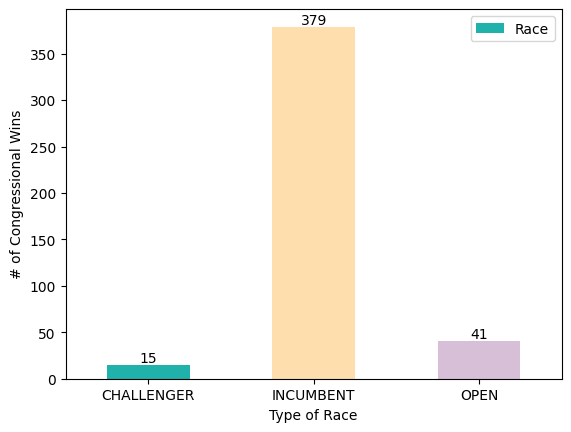

In [26]:
type_of_winner_plot = type_of_winner.plot.bar(y="Race",rot=0, color=["lightseagreen","navajowhite","thistle"])
type_of_winner_plot.set_ylabel("# of Congressional Wins")
type_of_winner_plot.set_xlabel("Type of Race")
type_of_winner_plot.bar_label(type_of_winner_plot.containers[0],fmt="%d")

Here we have a simple visualization of the types of winners out of the 435 elected congresspeople. We can see that 96% of incumbents won their race and that only 4% of them lost. This helps give the overall persepctive for when we compare types of races that a majority of wins are from incumbent canidates.

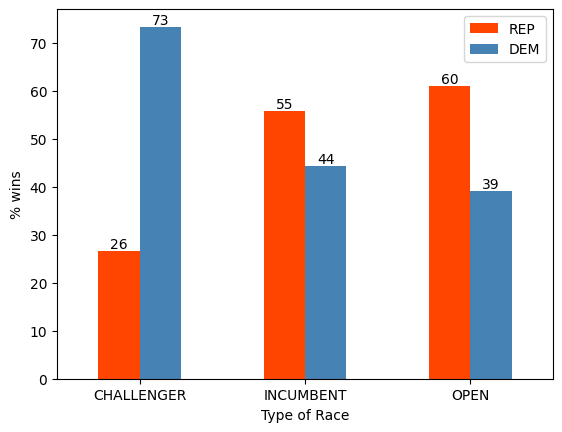

In [27]:
type_with_party_df = pd.DataFrame({'REP': [26.67,55.67,60.97],
                   'DEM': [73.3,44.32,39.02]}, index=["CHALLENGER","INCUMBENT","OPEN"])
type_with_party_visual = type_with_party_df.plot.bar(rot=0, color = {"REP": "orangered", "DEM": "steelblue"})
type_with_party_visual.set_ylabel("% wins")
type_with_party_visual.set_xlabel("Type of Race")
for container in type_with_party_visual.containers:
    type_with_party_visual.bar_label(container,fmt="%d")

Next within the three types of race winners, I wanted to see what the party distribution looked like. We can clearly see that democrats were far more successfull in flipping districts but at the same time also struggled a bit to maintain their seats. While the chart does show republicans doing far better in terms of open seats, without knowing what the incumbent's party affiliation was for the "open" races, not much can be interpreted from this metric.

[Text(0, 0, '4071904'), Text(0, 0, '1868635'), Text(0, 0, '4710683')]

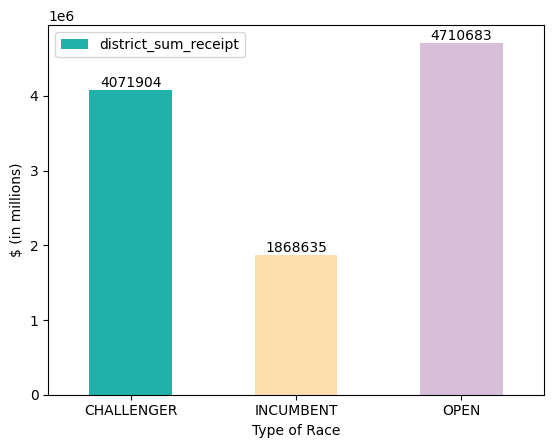

In [28]:
district_total_receipt_plot = winning_data.groupby("can_inc_cha_ope_sea").mean().round().plot.bar(y="district_sum_receipt",color=["lightseagreen","navajowhite","thistle"],rot=0)
district_total_receipt_plot.set_ylabel("$ (in millions)")
district_total_receipt_plot.set_xlabel("Type of Race")
district_total_receipt_plot.bar_label(district_total_receipt_plot.containers[0],fmt="%d")

Another interesting metric is how much money is being put into each of these congressional races. From the bar chart we can see that challenger winning and open races are averaging around 4 million dollars with incumbent winning races slightly under half of both hovering around 1.9 million dollars. This poses the interesting question if the sum of a district's canidates total receipts can be used as an indicator if the incumbent will lose the race. I do believe that this is a biased interpretation since only races that are close to being flipped would recieve a serious amount of funding due to the high chance of winning.

In [29]:
lower_receipts = winning_data.loc[winning_data["diff_receipts"] < 0]
lower_receipts

,Race,can_nam,can_par_aff,can_inc_cha_ope_sea,tot_rec,votes,mean_receipt,district_sum_receipt,diff_receipts,position_receipts,number_can,percent_receipts,pos_frac,district_pop
237,MN-2,"LEWIS, JASON MARK MR.",REP,OPEN,787946.0,174030.0,858827,7729440,-70881.0,4,9,10.194089,4/9,695029
220,MN-8,"NOLAN, RICHARD M.",DEM,INCUMBENT,2574298.0,179106.0,2930392,5860783,-356094.0,2,2,43.924131,2/2,663670
355,NY-22,"TENNEY, CLAUDIA",REP,OPEN,725136.0,120777.0,869368,6085574,-144232.0,4,7,11.915655,4/7,720690


One observation made is that out of the 435 congressional races, there were only 3 races where the winner had a below average total receipts amount. We can see that here with Lewis, Nolan and Tenney with two of the races being in Minnesota. This then means that the other 432 races, the winner had above average total recipts. Next I wanted to know what the relationship was like between not being the top fundraiser and winning, to see how strong of an indicator being first in fundraising was.

[Text(0, 0, '407'), Text(0, 0, '24'), Text(0, 0, '1'), Text(0, 0, '3')]

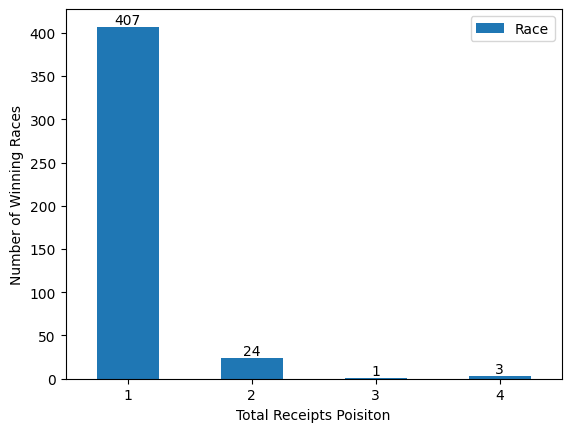

In [30]:
position_count_graph = winning_data.groupby("position_receipts").count().plot.bar(y="Race",rot=0)
position_count_graph.set_xlabel("Total Receipts Poisiton")
position_count_graph.set_ylabel("Number of Winning Races")
position_count_graph.bar_label(position_count_graph.containers[0],fmt="%d")

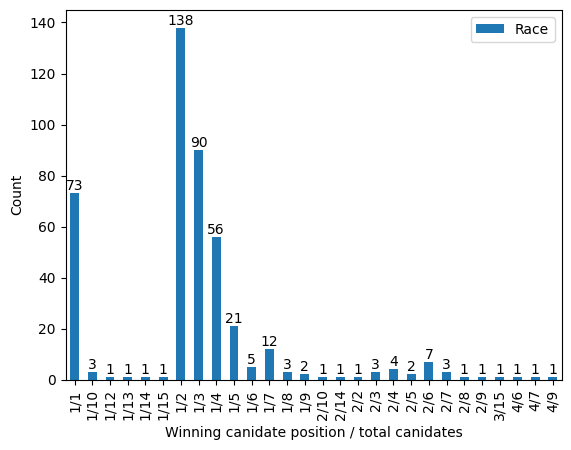

In [31]:
frac_position_graph = winning_data.groupby("pos_frac").count().plot.bar(y="Race")
frac_position_graph.set_xlabel("Winning canidate position / total canidates")
frac_position_graph.set_ylabel("Count")
for container in frac_position_graph.containers:
    frac_position_graph.bar_label(container,fmt="%d")

Together these two graphs show the distribution of what position winning canidates were in terms of total receipts for their race. We can see that 94% of winners were leading in terms of fundraising. While I expected a strong correlation between being first in fundraising and winning their race, I did not nearly expect it to be this strong. The purpose of the second graph is to show and give context that even when canidates aren't first in terms of fundraising, there are 4+ canidates in their race making them still ahead of the curve. 

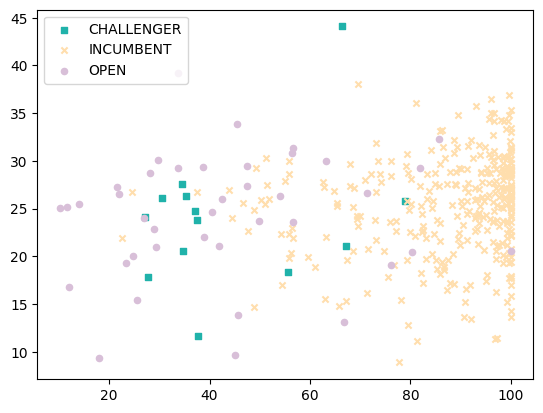

In [32]:
fig_2 = category_scatter(x='percent_receipts', y='percent_votes', label_col='can_inc_cha_ope_sea', 
                       data= winning_with_votes, colors=('lightseagreen', 'navajowhite', 'thistle'),alpha= 1, legend_loc='upper left')

Here I wanted to create a scatter plot looking at the relationship between percent of total receipts from district on the x axis vs percent of votes from district population on the y axis. Within this we created 3 symbols for each type of race winner. From this we can see that incumbent winners tend to have a larger portion of the district total receipts which makes sense since incumbent winning races tend to have fewer canidates running against them. Other than this there is not much that can be interpreted from the scatterplot since there seems to be very little correlation.

Text(0.5, 1.0, 'Receipts For Each Race Type')

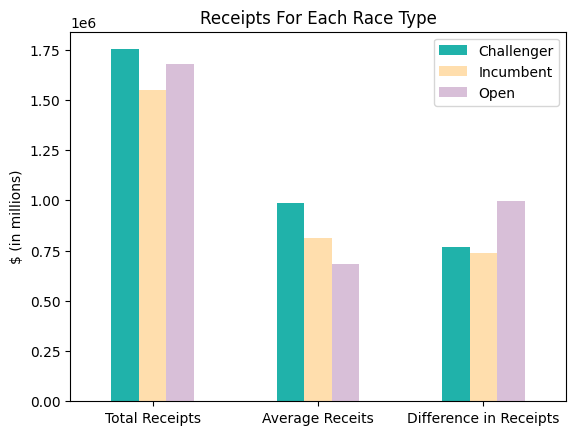

In [33]:
type_with_receipt_df = pd.DataFrame({'Challenger': [1751310,985876,765434],'Incumbent': [1549810,810268,739542],'Open': [1680050,682318,997732]}, index=["Total Receipts","Average Receits","Difference in Receipts"])
type_with_receit_visual = type_with_receipt_df.plot.bar(rot=0, color = {"Challenger": "lightseagreen", "Incumbent": "navajowhite", "Open": "thistle"})
type_with_receit_visual.set_ylabel("$ (in millions)")
type_with_receit_visual.set_title("Receipts For Each Race Type")

Here I wanted to compare the main metrix of receipts and it varied from each winnig race type. We can see that as noted before, incumbent winners typically need less money raised to win due to the advantages of being the incumbent canidate. We can also see that when looking at the average canidate's receipts for each type that challenger winning districts typically have more money going into them. This makes sense since if a challenger were to flip a seat, this means that it would be a close race and thus both parties would want to funnel as much money as possible to try to win over the seat.  

In [34]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 30,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = ["canidates (1397)", "challenger (688)", "incumbent (396)", "open (313)", "winner (435)", "loser","REP (240)","DEM (195)","1st (407)","2nd (24)","3rd (1)","4th (3)"],
      color = "dimgray"
    ),
    link = dict(
      source = [0, 0, 0,1,2,3,4,4,6,7,6,7,6,7], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 2, 3,4,4,4,6,7,8,8,9,9,11,10],
      value = [688, 396, 313,15,379,41,240,195,224,183,13,11,3,1]
  ))])
fig.update_traces(link_color=["lightseagreen","navajowhite","thistle","lightseagreen","navajowhite","thistle","lightcoral","lightsteelblue","lightcoral","lightsteelblue","lightcoral","lightsteelblue","lightcoral","lightsteelblue",], selector=dict(type='sankey'))
fig.update_layout(title_text="2016 House Winners Sankey Diagram", font_size=10)
fig.show()

![Imgur](https://i.imgur.com/yqSzWuB.png)

Lastly to sum up all of the previous visualizations, I wanted to create a Sankey diagram to show the traits of the 435 winning canidates out of the nearly 1400 canidates. Starting from the left we can see exactly how many of each kind of canidate was running for congress. Then through the next filter we can see the "ratio" of what proportion of these canidates won. As to be expected, most of the incumbents won, while very few challengers won, which is denoted by the line thickness. After that we can see the party splits for the house winners which slightly leans republican. Lastly we then look at the funding positions for each of these winners and once again the large width of the 1st place line shows how dominant of a factor leading in funding was for congressional race winners.

## Conclusions:

### Takeaways:

While it was to be expected, these visualizations of various measures accompanied with total receipts for 2016 congressional canidates helps show the power of being the top fundraiser in your race. With only 3 winners having less than the average total receipts, we can see how elections may not be the perfect "meritocracy" we would hope they would be. On top of this we were able to see the fundraising differences between the 3 types of races which illustrated how more money was being poured into more competitive races. 

### Limitations:

With us making intepreations off of the data it is important to understand the limitations of what we were working with. As stated previously, using population totals vs total votes or even # of eligible votes does not give us the best view in how many people each canidate was able to sway. On top of this, all of this data is only from one election cycle where a multitude of covariables could be at play. Lastly 50 of the winning canidates did not have any vote values in the dataset so we were unable to work with all 435 canidates for vote based metrics.

### Future Improvements:

Outside of what data was holding this analysis back in the limitations section, there were a number of other things that could have been done on top of this project given more time. For starters, looking at the total receipts distribution between individual donors and PAC's would have been an interesting path to go down. Another direction would have been to have the vote amounts for all canidates and not just winner so that more analysis could be done with votes. Lastly, knowing which party held the open district the term before would help give a more insightful look into the open races.

### Sources
Dataset: https://www.kaggle.com/datasets/danerbland/electionfinance

Sankley Diagram Code: https://plotly.com/python/sankey-diagram/

Population by District: https://ballotpedia.org/Demographics_of_congressional_districts_as_of_2015